Bibliography:

[1] [@bank2021autoencoders]: Dor Bank, Noam Koenigstein, and Raja Giryes. "Autoencoders." arXiv preprint arXiv:2003.05991 (2021).


# Visualising data with Autoencoders and Variational Autoencoders

### 1. FMNIST preparation

First download dataset from github.
https://github.com/zalandoresearch/fashion-mnist

I recommend to clone their repository (Best to do that outside of your local repo)
It will also provide us with loading functions

git clone https://github.com/zalandoresearch/fashion-mnist.git   

If cloned images/labels should be in fashion-mnist\data\fashion


In [67]:
import sys
#set your path to the fashion-mnist/utils folder
sys.path.append('../fashion-mnist/utils')
import mnist_reader


In [68]:
X_train, y_train = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='t10k')

In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


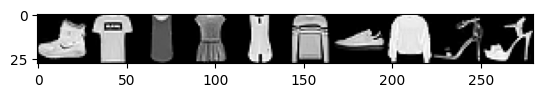

In [70]:
#show first 10 images 
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')

In [71]:
X_train.min(), X_train.max()


(0, 255)

Lets normalize data to 0,1

In [72]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()


### 2. Autoencoders 
Network trained to reduce number of dimmensions in data while perserving minimal reconstruction loss of information.
It's composed of 2 layers where one compresses and second one decompresses input data. While both compresser and decompresser are trained silmutainously they minimise loss of information after that 2 procedures. 

   - Zastosowania Autoencoderów


Dimensionality Reduction (reducing number of dimmensions of input data)

- It can be used as lossy Image/Audio Compression 
- even as substitute of methods like TSNE to compress numerical data into 2/3 dimmensions to plot them.

Image Denoising - AE can be trained to recover data from noised verision (ex. Variational AutoEncoder)

Variational Autoencoder about which will be next section can also be used for generative modeling.

    




   - Model explanation (encoding - decoding)


![
    Autoencoder model architecture from [1] [@bank2021autoencoders]
](aemodel.png)
 
 Autoencoder model architecture from [1] [@bank2021autoencoders]

Autoencoders are models that are composed of 2 sections: Encoding layer, Decoding layer.


Both are simple dense layers where encoding should be of size:

`INPUT_SIZE` -> `LATENT SPACE SIZE`

where if we want it to encode, `LATENT SPACE` should be smaller than `INPUT_SIZE`. On its own, if we pass data through a layer that gives a smaller output, we will receive less information. That reduced form, which we will denote as `R`:

Input -> `ENCODER` -> Reduced representation `R`

That reduced output goes now to the second layer, which is `DECODER`. The decoder does the inverse mechanism. It will be a dense layer that should, as input, take 

`LATENT SPACE SIZE` data and transform it back to `INPUT_SIZE` data.

`INPUT_SIZE` -> `LATENT SPACE SIZE` -> `LATENT SPACE SIZE` -> `INPUT_SIZE`


In [73]:
#show size of input data
print(X_train.shape)

(60000, 784)


`INPUT SIZE` is 784

As `LATENT SPACE SIZE` we need something smaller and for this to be visualisable lets keep it square: for example 20*20 = 400


So in summary
ENCODER:

- Dense layer (INPUT_SIZE -> LATENT)
- Activation function ( sigmoid best as it gives output in 0-1)

->

DECODER:

- Dense layer (LATENT -> INPUT_SIZE)
- Activation function ( sigmoid best as it gives output in 0-1)


In [74]:
BATCH_SIZE = 64
INPUT_SIZE = 28*28
LATENT_SPACE_SIZE = 20*20
LATENT_SPACE_SHAPE = (20,20)
LATENT_SPACE_SIDE = 20

In [75]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, latent_space_size = LATENT_SPACE_SIZE):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2,latent_space_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2, input_size),
            nn.Sigmoid()
        )
        self.latent_space_shape = latent_space_size
        
    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    
    def loss_calculation(self, recon_x, x, loss_func):
        loss = loss_func(recon_x, x)
        return loss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### training

Having a way to compress and decompress data now it's time to direct this mechanism into better results.
As the cost function we will calculate difference between input_image and output after encoding and decoding.
Our goal is to train encoder and decoding layer is mostly used for training so that we are able to compare output with input.

A -> encode -> B -> decode -> C

    cost = abs( A - C ) loss of information which we want to minimalize

Knowing what we want from our cost function we will use MSE: 
mean square error which will look like this:

    cost = mean( (A - C)^2 )

In [76]:
def ae_cost_function(model, recon_x, x):
    MSE = nn.MSELoss()
    return MSE(recon_x, x)

Before training let's also prepare function that will allow us to preview image in reduced representation, to validate empirically our progress.

In [98]:
import torch
import math

def sample(model, test_samples):
    model.eval()
    with torch.no_grad():
        return model(test_samples)
    
def preview_samples( samples, image_shape=(28,28) ):
    plt.imshow(np.hstack(samples.reshape(-1 ,image_shape[0], image_shape[1])))
    plt.show()

def plot_3_sample_rows(input, latent, output):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original samples")
    plt.imshow(input)
    plt.subplot(1, 3, 2)
    plt.title("Compressed samples")
    plt.imshow(latent)

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed samples")
    plt.imshow(output)
    plt.show()

def plot_compression_process(model, input_data, input_output_shape, latent_size ):
    samples = input_data
    side = int(math.sqrt(latent_size))
    
    latent_shape = (side, latent_size//side)

    input_image = np.hstack(samples.reshape(-1 ,input_output_shape[0], input_output_shape[1]))
    
    compressed_samples = model.encode(samples).detach().numpy()
    latent_image = np.hstack(compressed_samples.reshape(-1 , *latent_shape))

    reconstructed_samples = model.decode(torch.tensor(compressed_samples)).detach().numpy()
    decompressed_image = np.hstack(reconstructed_samples.reshape(-1 ,input_output_shape[0], input_output_shape[1]))
    plot_3_sample_rows(input_image, latent_image, decompressed_image)

In [82]:
def train_ae_variations(model,
                        loss_function,
                        batch_size= BATCH_SIZE, 
                        epochs=5, 
                        learning_rate=1e-4, 
                        plot_2d_latent = False, 
                        plot_decompressed = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    data = torch.utils.data.DataLoader(X_train.view(-1, INPUT_SIZE), batch_size=batch_size, shuffle=True)
    
    for i in range(epochs):
        batch_loss = 0
        for batch in data:
            optimizer.zero_grad()
            recon_batch = model(batch)
            loss = loss_function(model, recon_batch, batch)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        loss_history.append(batch_loss/len(data))
        print(f'Epoch {i} Loss: {loss.item()}')
        if(plot_2d_latent):
            compressed_samples = model.encode(X_test.view(-1, INPUT_SIZE)).detach().numpy()
            plt.scatter(compressed_samples[:,0], compressed_samples[:,1], c=y_test, cmap='tab10')
            plt.colorbar()
            plt.show()
            
        if(plot_decompressed):
            sample_data = X_test[:10].view(-1, INPUT_SIZE)
            plot_compression_process(model, sample_data, (28,28), model.latent_space_shape)
            
    return loss_history

In [83]:
#split training data into batches
EPOCHS = 5
BATCH_SIZE = 120
LEARNING_RATE = 1e-4

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
batched_data = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)

E:\Users\qesterius\AppData\Local\Temp\ipykernel_13264\2572625180.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
E:\Users\qesterius\AppData\Local\Temp\ipykernel_13264\2572625180.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Epoch 0 Loss: 0.030447466298937798
(20, 20)


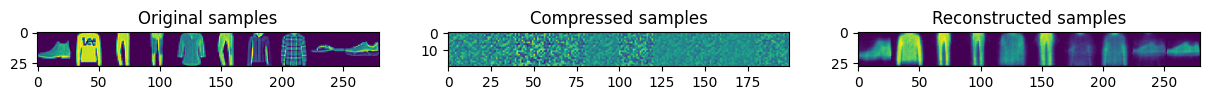

Epoch 1 Loss: 0.022133663296699524
(20, 20)


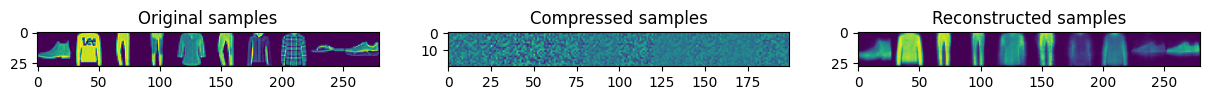

Epoch 2 Loss: 0.02080392837524414
(20, 20)


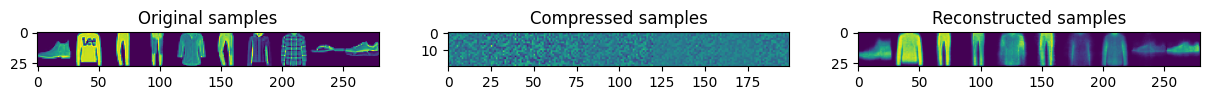

Epoch 3 Loss: 0.018536711111664772
(20, 20)


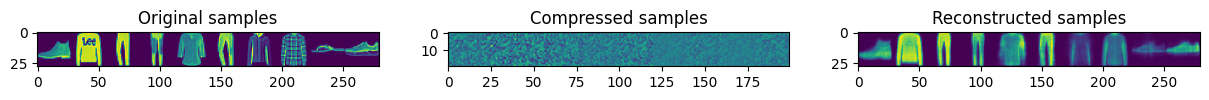

Epoch 4 Loss: 0.016776449978351593
(20, 20)


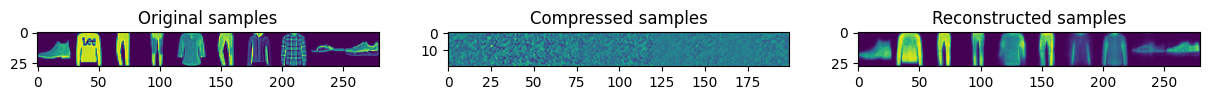

In [84]:
ae = Autoencoder()
loss_history = train_ae_variations(ae, ae_cost_function, epochs=EPOCHS, learning_rate=LEARNING_RATE, plot_decompressed=True)

   - Encoding to 2 dimensions and plotting.

   We can use it to visualize data as point in embedded space. Each image will be converted into 2 dimmensional point (2 values).

In [85]:
def plot_2d_representation(x, y):
    plt.scatter(x[:,0],x[:,1] , c=y, cmap='tab10')
    plt.colorbar()
    plt.show()
    

Epoch 0 Loss: 0.044616833329200745


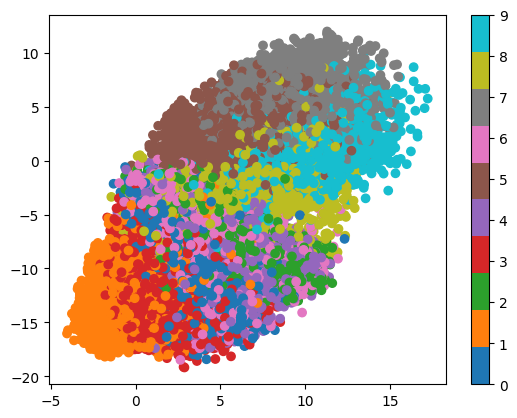

Epoch 1 Loss: 0.03609580919146538


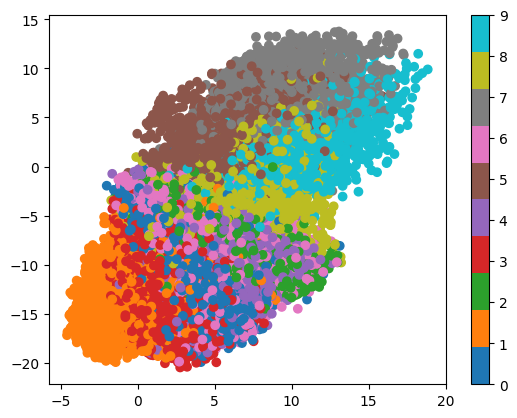

Epoch 2 Loss: 0.03302376717329025


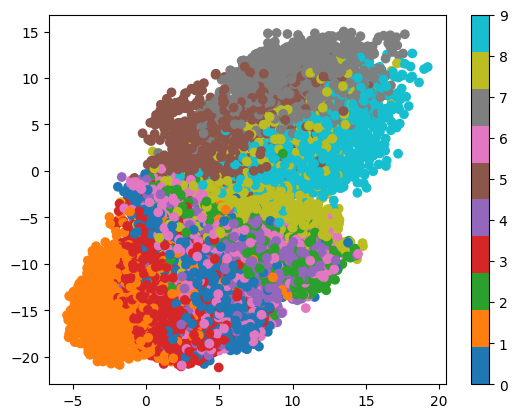

Epoch 3 Loss: 0.03177564963698387


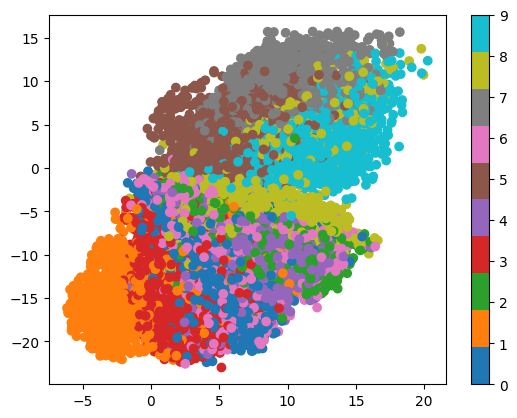

Epoch 4 Loss: 0.03327146917581558


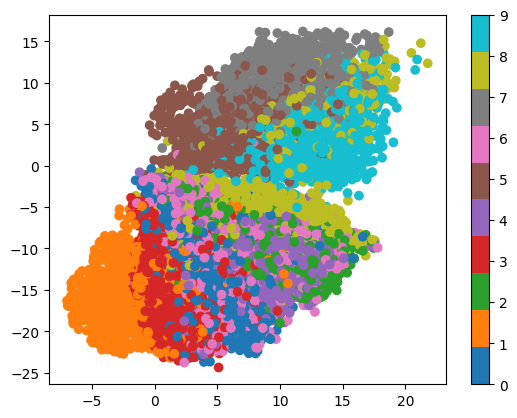

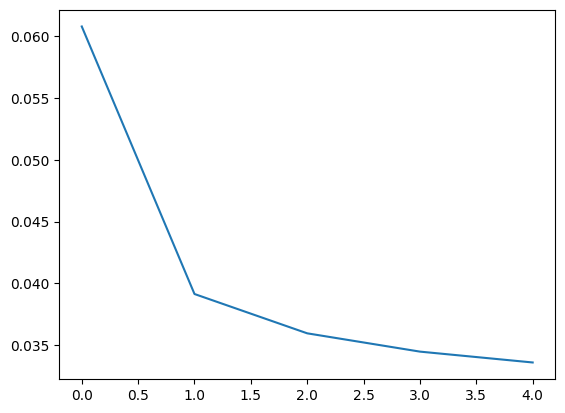

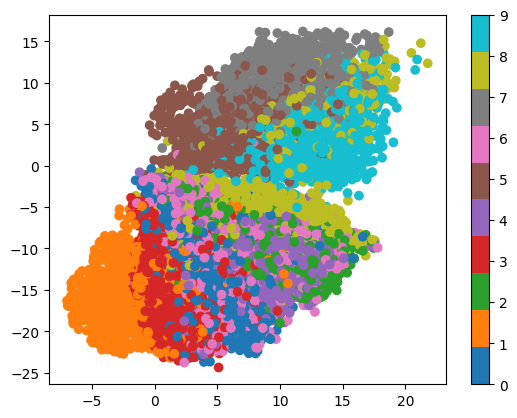

In [90]:
ae = Autoencoder(latent_space_size=2)
loss_history = train_ae_variations(ae, ae_cost_function, epochs=5, plot_2d_latent=True)
plt.plot(loss_history)
plt.show()    

test_2d_representation = ae.encode(X_test.view(-1, INPUT_SIZE)).detach().numpy()
plot_2d_representation(test_2d_representation, y_test )



### 3. Variational Autoencoder 
   - Model explanation 
   - Mathematical formulas for noise injection 
   - Encoding to 2 dimensions and plotting
   - Probkowanie fantazji sieci


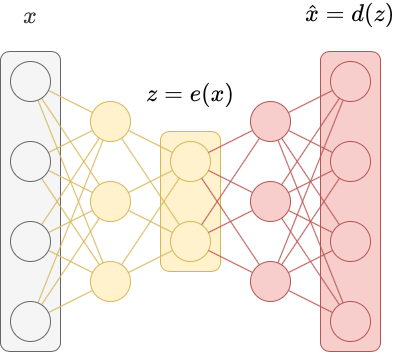

In [91]:
#Variational Autoencode
class VariationalEncoder(nn.Module):
    def __init__(self, input_size, latent_dims):
        super(VariationalEncoder, self).__init__()
        hidden_dim = input_size//2
        self.linear1 = nn.Linear(input_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, latent_dims)
        self.linear3 = nn.Linear(hidden_dim, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.nn.functional.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - torch.log(sigma) - 1, dim=1).mean()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, latent_space_size = LATENT_SPACE_SIZE):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_size, latent_space_size)
        hidden_dim = input_size//2
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_size),
            nn.Sigmoid()
        )
    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    def loss_calculation(self, recon_x, x, loss_func):
        loss = loss_func(recon_x, x) + self.encoder.kl
        return loss
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEEncoder, self).__init__()

        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_mean  = nn.Linear(hidden_dim, latent_dim)
        self.linear_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.linear_1(x))
        h_       = self.LeakyReLU(self.linear_2(h_))
        mean     = self.linear_mean(h_)
        log_var  = self.linear_var(h_)                     # encoder produces mean and log of variance 
                                                           #(i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var
    
    
    
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAEDecoder, self).__init__()
        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.linear_1(x))
        h     = self.LeakyReLU(self.linear_2(h))
        
        x_hat = torch.sigmoid(self.hidden_3(h))
        return x_hat
        
class VAEModel(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAEModel, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)     # sampling epsilon        
        z = mean + var*epsilon         # reparameterization trick
        return z
        
    def encode(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var


In [92]:
def vae_cost_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [95]:
from torch.optim import Adam
encoder = VAEEncoder(input_dim=INPUT_SIZE, hidden_dim=INPUT_SIZE//2, latent_dim=2)
decoder = VAEDecoder(latent_dim=2, hidden_dim = INPUT_SIZE//2, output_dim = INPUT_SIZE)

model = VAEModel(Encoder=encoder, Decoder=decoder)
optimizer = Adam(model.parameters(), lr = 0.001)

Start training VAE...
	Epoch 1 complete! 	Average Loss:  29.51175762125651


TypeError: Invalid shape (20,) for image data

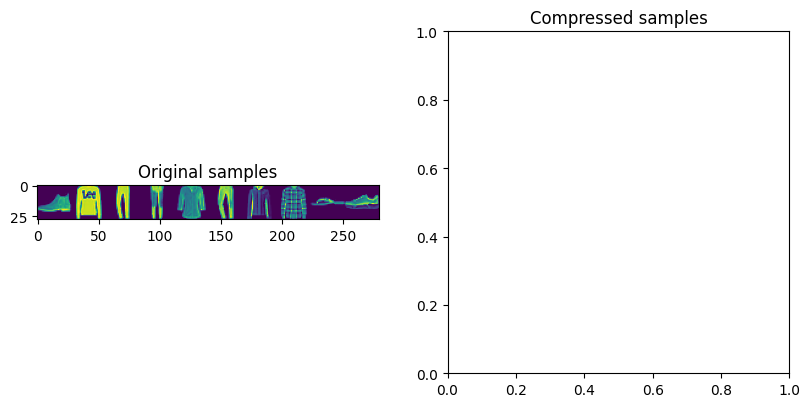

In [100]:
print("Start training VAE...")
model.train()            
loss_history = []

for epoch in range(EPOCHS*10):
    overall_loss = 0
    i=0
    
    for batch in batched_data:
        i+=1
        x = batch

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = vae_cost_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*BATCH_SIZE))
    sample_data = X_test[:10].view(-1, INPUT_SIZE)
    input_image = np.hstack(sample_data.detach().numpy().reshape(-1 ,28, 28))
    compressed_samples = model.encode(sample_data).detach().numpy()
    compressed_image = np.hstack(compressed_samples.reshape(-1 ,2, 1))
    reconstructed_samples = model(sample_data)[0].detach().numpy()
    plot_3_sample_rows(input_image, compressed_image, np.hstack(reconstructed_samples.reshape(-1 ,28, 28)))
    
    
#plot loss
plt.plot(loss_history)
plt.show()
print("Finish!!")


#testing
model.eval()
encoded = model.encode(X_test.view(-1, INPUT_SIZE)).detach().numpy()
print(ae_cost_function(model, encoded , X_test.view(-1, INPUT_SIZE)))

<h1>#TODO: COS JEST NIE TAK Z TYM VAE BO PO DODANIU KL DO LOSS PIERDOLI SIE FEST!!!</h1>

Epoch 0 Loss: -0.06791342049837112


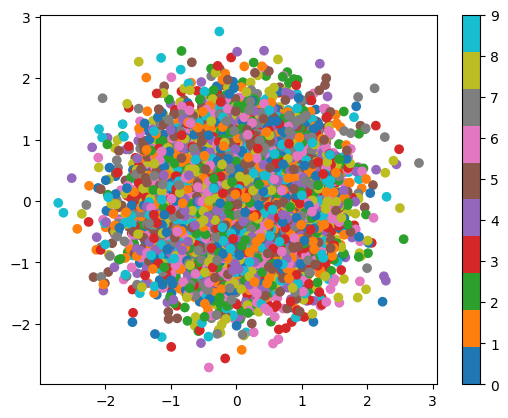

Epoch 1 Loss: -0.06228703260421753


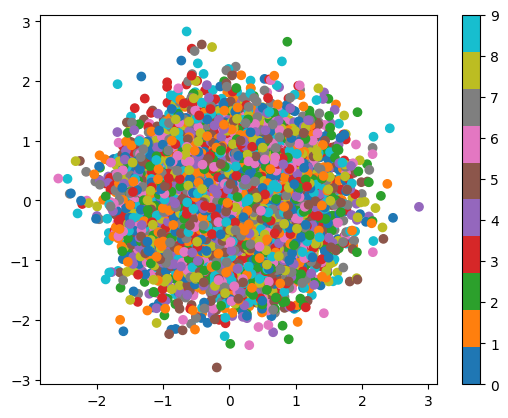

Epoch 2 Loss: -0.07012010365724564


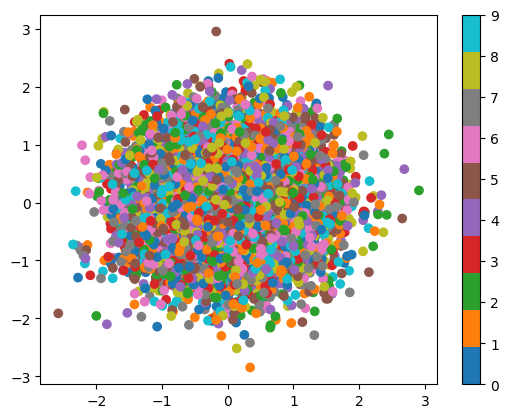

Epoch 3 Loss: -0.0611753985285759


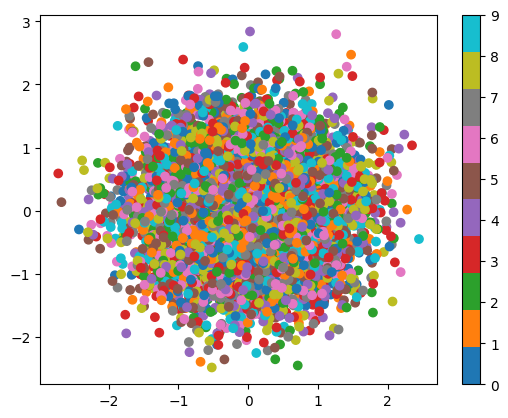

Epoch 4 Loss: -0.07028795778751373


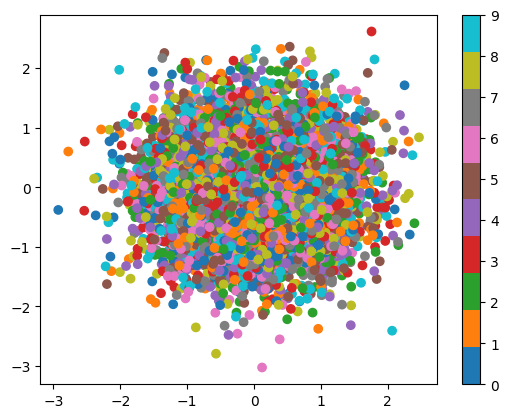

Epoch 5 Loss: -0.060686565935611725


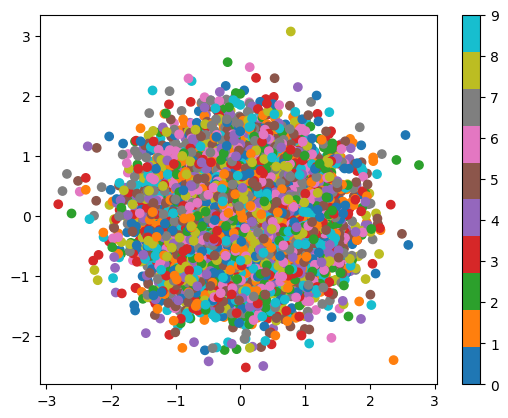

Epoch 6 Loss: -0.06957992911338806


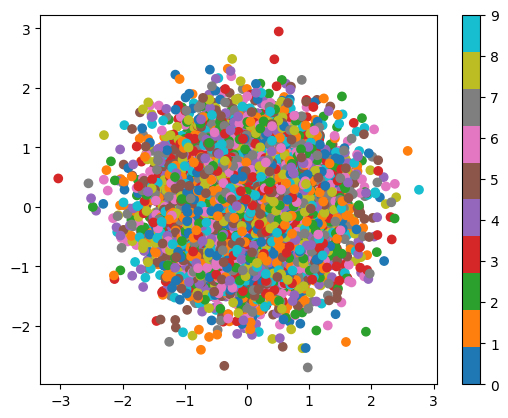

Epoch 7 Loss: -0.06490577012300491


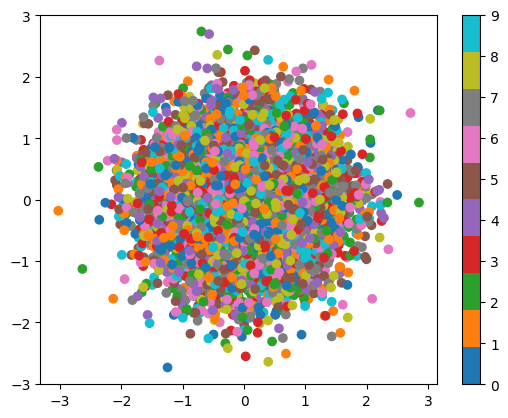

Epoch 8 Loss: -0.06674476712942123


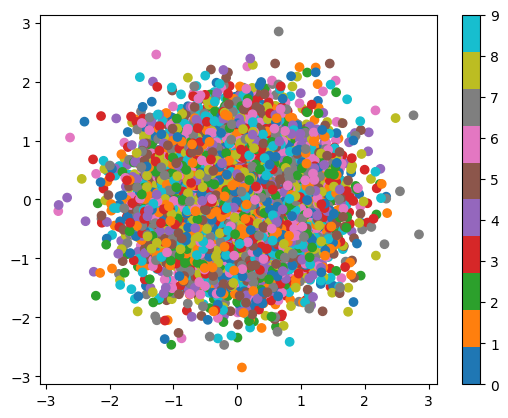

Epoch 9 Loss: -0.06665222346782684


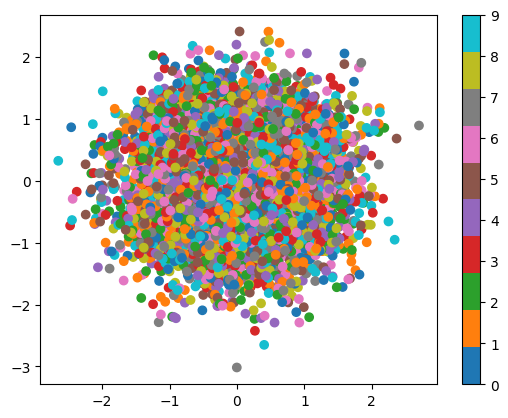

Epoch 10 Loss: -0.06741722673177719


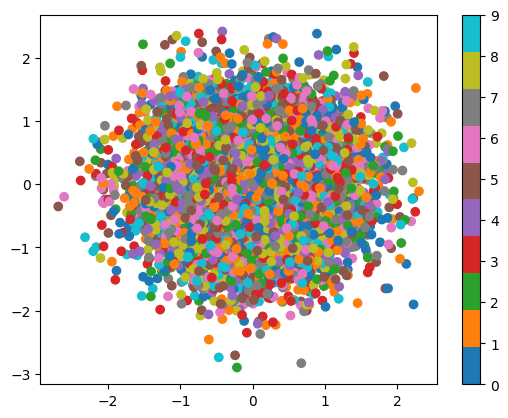

Epoch 11 Loss: -0.06936166435480118


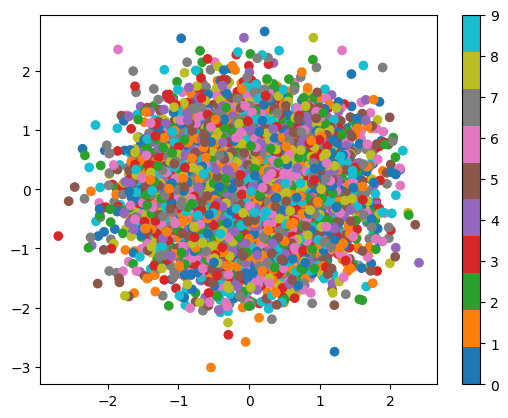

Epoch 12 Loss: -0.06783609092235565


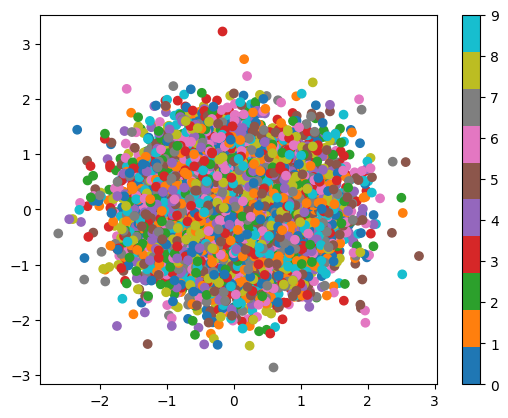

Epoch 13 Loss: -0.0686662346124649


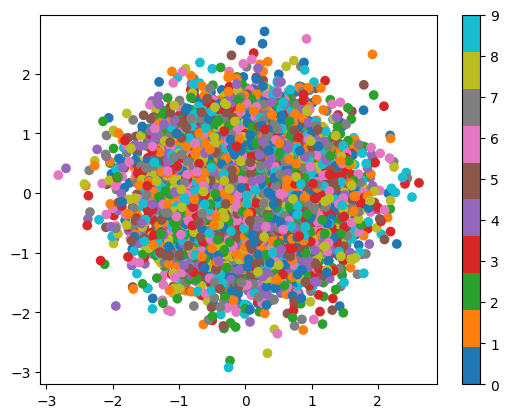

Epoch 14 Loss: -0.06788618117570877


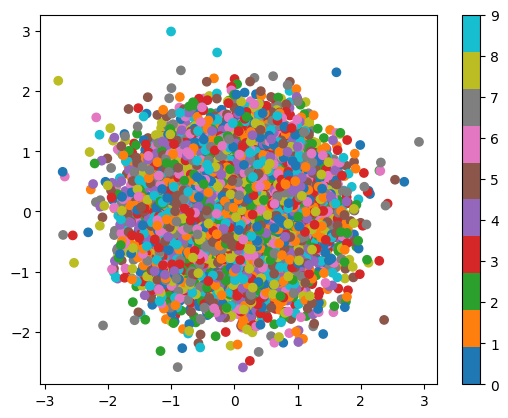

Epoch 15 Loss: -0.07178889214992523


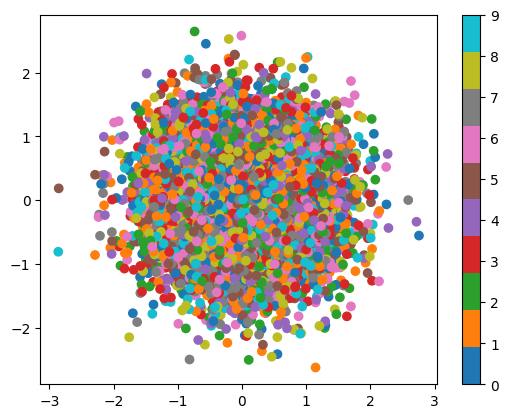

Epoch 16 Loss: -0.06227748095989227


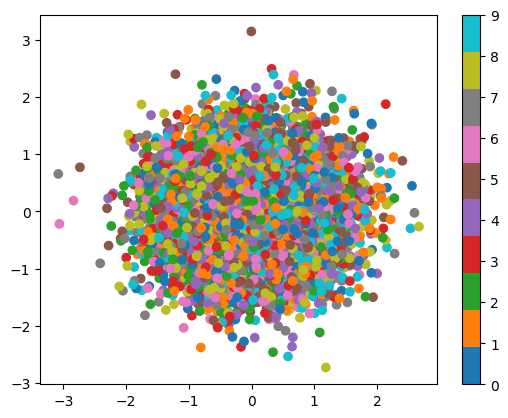

Epoch 17 Loss: -0.06873258948326111


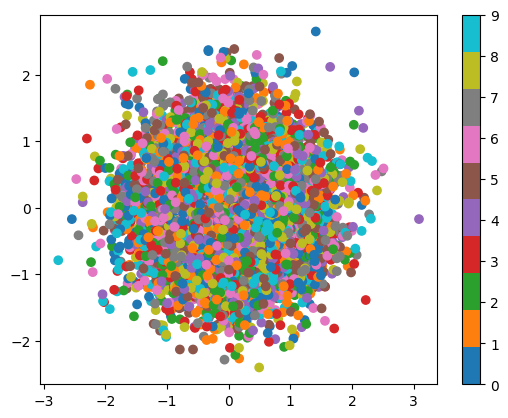

Epoch 18 Loss: -0.06264584511518478


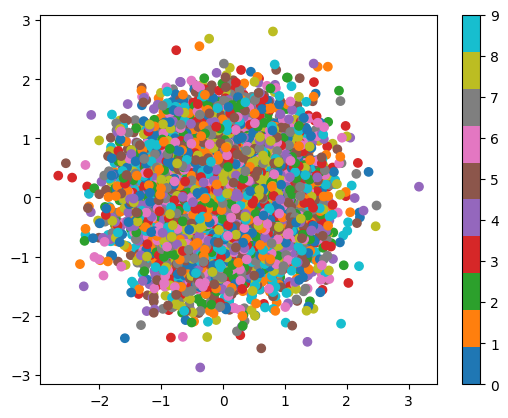

Epoch 19 Loss: -0.06896258890628815


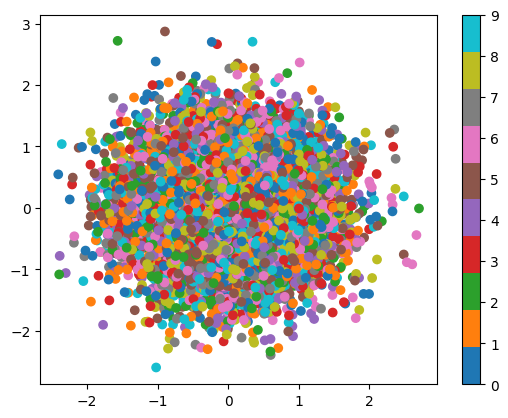

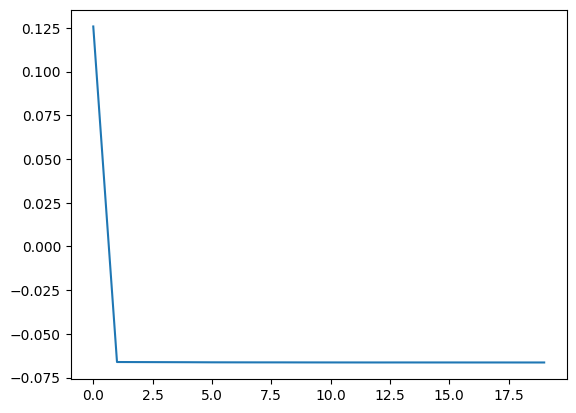

VariationalAutoencoder
Original samples


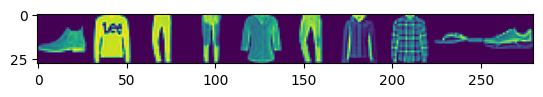

Compressed samples


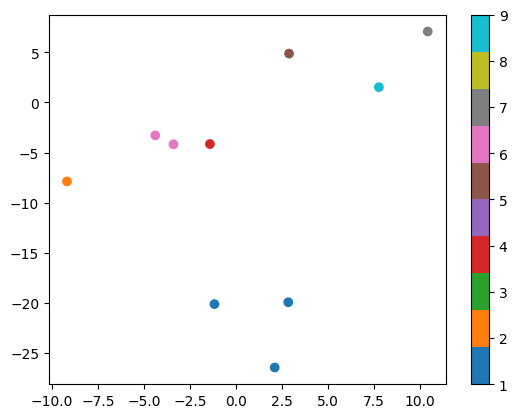

Reconstructed samples


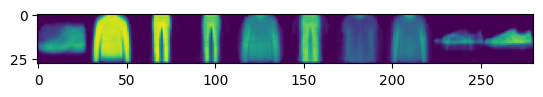

In [ ]:
#print learning curve
vae = VariationalAutoencoder(latent_space_size=2)
loss_history = train_ae_variations(vae, batched_data, epochs=20, plot_2d_latent=True, learning_rate=1e-2)
plt.plot(loss_history)
plt.show()    
    
print('VariationalAutoencoder')
preview_encoding_decoding_2d(ae, X_test[:10], y_test[:10])

### 4. Porównanie dwóch metod
